<a href="https://colab.research.google.com/github/macknever/CPSC-533R/blob/master/CPSC_533R__Assignment1_Yuansi_Li_Task_II_VIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here are task II to VIII. I refered [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

I made a new __getitem__() here to return a dictionary

In [0]:
#use dictionary

#override the __getitem__ function
class Dataset(torchvision.datasets.CIFAR10):
    def __getitem__(self, item):
        i,l = super().__getitem__(item)
        dic = {'img':i,'label':l}
        return dic

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


I loaded dataset from CIFAR10, which contains (3*32*32) image dataset.

In [111]:
trainset = Dataset(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = Dataset(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

What I did is to classify the pic.

In [0]:
def imshow(img):
    img = img / 2 +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
   

Task VI

   cat  ship plane   cat


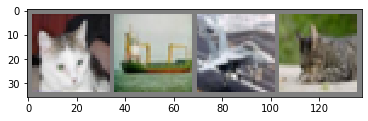

In [114]:
# get some random training images
dataiter = iter(trainloader)
dic = dataiter.next()
images, labels = dic['img'], dic['label']
# print(images)
#show images

imshow(torchvision.utils.make_grid(images))
print(''.join('%6s' % classes[labels[j]] for j in range(4)))

Here, is for task III & IV. the forward() function now can receive a dic type argu to compute forward, and return a dict type.

In [0]:
class NN(nn.Module):

    def __init__(self):
        super(NN,self).__init__()

        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,3)
        self.conv3 = nn.Conv2d(16,32,3)

        self.fc1 = nn.Linear(32*2*2,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
#modifed forward function
    def forward(self,dic):
        x = dic['img']
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = F.max_pool2d(F.relu(self.conv3(x)),2)

        x = x.view(-1,32*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        label = {'label':x}
        return label

net = NN()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

Task V,VII

In [117]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #outputs = net(data)
        outputs = net(data)
        loss = criterion(outputs['label'], data['label'])
        #loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.300
[1,  6000] loss: 2.171
[1,  8000] loss: 1.894
[1, 10000] loss: 1.756
[1, 12000] loss: 1.643
[2,  2000] loss: 1.573
[2,  4000] loss: 1.538
[2,  6000] loss: 1.507
[2,  8000] loss: 1.487
[2, 10000] loss: 1.436
[2, 12000] loss: 1.436
Finished Training


Task VIII

In [0]:
#store the trained net
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [0]:
dataiter = iter(testloader)
input = dataiter.next()
images, labels = input['img'],input['label']

GroundTruth:    cat  ship  ship plane


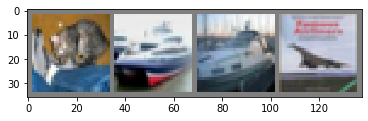

In [120]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [121]:
#load back the trained net
net = NN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [122]:
outputs = net(input)

_, predicted = torch.max(outputs['label'], 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [123]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data['img'],data['label']
        outputs = net(data)
        _, predicted = torch.max(outputs['label'], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


In [124]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data['img'],data['label']
        outputs = net(data)
        _, predicted = torch.max(outputs['label'], 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 42 %
Accuracy of   car : 70 %
Accuracy of  bird : 42 %
Accuracy of   cat : 22 %
Accuracy of  deer : 33 %
Accuracy of   dog : 44 %
Accuracy of  frog : 57 %
Accuracy of horse : 67 %
Accuracy of  ship : 71 %
Accuracy of truck : 51 %
